# About this notebook
- Deberta-v3-large starter code
- pip wheels is [here](https://www.kaggle.com/code/yasufuminakama/pppm-pip-wheels)
- Inference notebook is [here](https://www.kaggle.com/code/yasufuminakama/pppm-deberta-v3-large-baseline-inference)

If this notebook is helpful, feel free to upvote :)

### embedを得るためのnote

In [1]:
! nvidia-smi

Sat Jun  4 23:00:29 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Directory settings

In [2]:
# ====================================================
# Directory settings
# ====================================================
import os
import sys
import json
# INPUT_DIR = '../input/us-patent-phrase-to-phrase-matching/'
# OUTPUT_DIR = './'
# if not os.path.exists(OUTPUT_DIR):
#     os.makedirs(OUTPUT_DIR)

# CFG

In [3]:
# ====================================================
# CFG
# ====================================================
class CFG:
    wandb=False
    competition='PPPM'
    _wandb_kernel='nakama'
    debug=False
    apex=True
    print_freq=100
    num_workers=4
    model="microsoft/deberta-v3-large"
    scheduler='cosine' # ['linear', 'cosine']
    batch_scheduler=True
    num_cycles=0.5
    num_warmup_steps=500
    epochs=4
    encoder_lr=1.5e-5
    decoder_lr=1.5e-5
    min_lr=1e-6
    eps=1e-6
    betas=(0.9, 0.999)
    batch_size=16
    fc_dropout=0.2
    target_size=1
    max_len=512
    weight_decay=0.01
    gradient_accumulation_steps=1
    max_grad_norm=1000
    seed=42
    n_fold=10
    trn_fold=[0, 1, 2, 3]
    train=True
    newtrain = False

    name = "exp017c" # 実験のたびにコピーしてここの名前を変えて実行するとoutputが別のファイルに保存される
    api_path = "/content/drive/MyDrive/kaggle/kaggle.json"
    drive_path = "/content/drive/MyDrive/kaggle/PPPM"
    
if CFG.debug:
    CFG.epochs = 2
    CFG.trn_fold = [0]

In [4]:
COLAB = "google.colab" in sys.modules

In [5]:
!pip install --upgrade --force-reinstall --no-deps kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 58 kB 6.0 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=89c9534203aebf457cb60bcd2f41191a240aca898af14d99871a3c44a1f33dd6
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [6]:
if COLAB:
    print("This environment is Google Colab")
    
    # mount
    from google.colab import drive
    if not os.path.isdir("/content/drive"):
        drive.mount('/content/drive') 
	
    
    # use kaggle api (need kaggle token)
    f = open(CFG.api_path, 'r')
    json_data = json.load(f) 
    os.environ["KAGGLE_USERNAME"] = json_data["username"]
    os.environ["KAGGLE_KEY"] = json_data["key"]
    
    # set dirs
    DRIVE = CFG.drive_path
    EXP = CFG.name
    INPUT_DIR = os.path.join(DRIVE, "Input")
    OUTPUT_DIR = os.path.join(DRIVE, "Output")
    SCRIPT = os.path.join(DRIVE, "Script")
    OUTPUT_DIR = os.path.join(OUTPUT_DIR, EXP) 
    # EXP_MODEL = os.path.join(OUTPUT_EXP, "model")
    # EXP_FIG = os.path.join(OUTPUT_EXP, "fig")
    # EXP_PREDS = os.path.join(OUTPUT_EXP, "preds")

    # make dirs
    for d in [INPUT_DIR, SCRIPT, OUTPUT_DIR]:
        os.makedirs(d, exist_ok=True)

    if not os.path.isfile(os.path.join(INPUT_DIR, "us-patent-phrase-to-phrase-matching.zip")):
        # load dataset
        ! kaggle competitions download -c us-patent-phrase-to-phrase-matching -p $INPUT_DIR 
        unzip_file = os.path.join(INPUT_DIR, 'us-patent-phrase-to-phrase-matching.zip')
        ! unzip $unzip_file -d $INPUT_DIR
    
    if not os.path.isfile(os.path.join(INPUT_DIR, "cpc-data.zip")):
        # load dataset
        ! kaggle datasets download -d yasufuminakama/cpc-data -p $INPUT_DIR
        unzip_file = os.path.join(INPUT_DIR, 'cpc-data.zip')
        ! unzip $unzip_file -d $INPUT_DIR

else:
    print("This environment is Kaggle Kernel")
    
    # set dirs
    INPUT_DIR = '../input/us-patent-phrase-to-phrase-matching/'
    OUTPUT_DIR = './'
    
    
    # # copy dirs
    # if Config.kaggle_dataset_path is not None:
    #     KD_MODEL = os.path.join(Config.kaggle_dataset_path, "model")
    #     KD_EXP_PREDS = os.path.join(Config.kaggle_dataset_path, "preds")
    #     shutil.copytree(KD_MODEL, EXP_MODEL)
    #     shutil.copytree(KD_EXP_PREDS, EXP_PREDS)

    # # make dirs
    # for d in [EXP_MODEL, EXP_FIG, EXP_PREDS]:
    #     os.makedirs(d, exist_ok=True)
        
    

This environment is Google Colab
Mounted at /content/drive


In [7]:
# ====================================================
# wandb
# ====================================================
if CFG.wandb:
    
    import wandb

    try:
        from kaggle_secrets import UserSecretsClient
        user_secrets = UserSecretsClient()
        secret_value_0 = user_secrets.get_secret("wandb_api")
        wandb.login(key=secret_value_0)
        anony = None
    except:
        anony = "must"
        print('If you want to use your W&B account, go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as wandb_api. \nGet your W&B access token from here: https://wandb.ai/authorize')


    def class2dict(f):
        return dict((name, getattr(f, name)) for name in dir(f) if not name.startswith('__'))

    run = wandb.init(project='PPPM-Public', 
                     name=CFG.model,
                     config=class2dict(CFG),
                     group=CFG.model,
                     job_type="train",
                     anonymous=anony)

# Library

In [8]:
# ====================================================
# Library
# ====================================================
import os
import gc
import re
import ast
import sys
import copy
import json
import time
import math
import shutil
import string
import pickle
import random
import joblib
import itertools
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

import scipy as sp
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from tqdm.auto import tqdm
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold, StratifiedGroupKFold

import torch
print(f"torch.__version__: {torch.__version__}")
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.optim import Adam, SGD, AdamW
from torch.utils.data import DataLoader, Dataset
# !pip install transformers==4.18.0
!pip install transformers[sentencepiece]
!pip install tokenizers==0.12.1
import tokenizers
import transformers
print(f"tokenizers.__version__: {tokenizers.__version__}")
print(f"transformers.__version__: {transformers.__version__}")
from transformers import AutoTokenizer, AutoModel, AutoConfig
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
%env TOKENIZERS_PARALLELISM=true

import lightgbm as lgb

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch.__version__: 1.11.0+cu113
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 5.4 MB/s 
     |████████████████████████████████| 86 kB 2.8 MB/s 
     |████████████████████████████████| 596 kB 18.2 MB/s 
     |████████████████████████████████| 6.6 MB 18.1 MB/s 
     |████████████████████████████████| 1.2 MB 57.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
tokenizers.__version__: 0.12.1
transformers.__version__: 4.19.2
env: TOKENIZERS_PARALLELISM=true


# Utils

In [9]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    score = sp.stats.pearsonr(y_true, y_pred)[0]
    return score


def get_logger(filename=OUTPUT_DIR+'/train'):
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = get_logger()

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=42)

# Data Loading

In [10]:
# ====================================================
# Data Loading
# ====================================================
train = pd.read_csv(INPUT_DIR+'/train.csv')
test = pd.read_csv(INPUT_DIR+'/test.csv')
submission = pd.read_csv(INPUT_DIR+'/sample_submission.csv')
print(f"train.shape: {train.shape}")
print(f"test.shape: {test.shape}")
print(f"submission.shape: {submission.shape}")
display(train.head())
display(test.head())
display(submission.head())

train.shape: (36473, 5)
test.shape: (36, 4)
submission.shape: (36, 2)


,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00


,id,anchor,target,context
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02
1,09e418c93a776564,adjust gas flow,altering gas flow,F23
2,36baf228038e314b,lower trunnion,lower locating,B60
3,1f37ead645e7f0c8,cap component,upper portion,D06
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04


,id,score
0,4112d61851461f60,0
1,09e418c93a776564,0
2,36baf228038e314b,0
3,1f37ead645e7f0c8,0
4,71a5b6ad068d531f,0


In [11]:
# ====================================================
# CPC Data
# ====================================================
def get_cpc_texts():
    contexts = []
    pattern = '[A-Z]\d+'
    if COLAB:
        cpcpath = os.path.join(INPUT_DIR, 'CPCSchemeXML202105')
    else:
        cpcpath = '../input/cpc-data/CPCSchemeXML202105'
    for file_name in os.listdir(cpcpath):
        result = re.findall(pattern, file_name)
        if result:
            contexts.append(result)
    contexts = sorted(set(sum(contexts, [])))
    results = {}
    for cpc in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'Y']:
        if COLAB:
            cpcpath = os.path.join(INPUT_DIR, f'CPCTitleList202202/cpc-section-{cpc}_20220201.txt')
        else:
            cpcpath = f'../input/cpc-data/CPCTitleList202202/cpc-section-{cpc}_20220201.txt'
        with open(cpcpath) as f:
            s = f.read()
        pattern = f'{cpc}\t\t.+'
        result = re.findall(pattern, s)
        cpc_result = result[0].lstrip(pattern)
        for context in [c for c in contexts if c[0] == cpc]:
            pattern = f'{context}\t\t.+'
            result = re.findall(pattern, s)
            results[context] = cpc_result + ". " + result[0].lstrip(pattern)
    return results


cpc_texts = get_cpc_texts()
torch.save(cpc_texts, OUTPUT_DIR+"/cpc_texts.pth")
train['context_text'] = train['context'].map(cpc_texts)
test['context_text'] = test['context'].map(cpc_texts)
display(train.head())
display(test.head())

,id,anchor,target,context,score,context_text
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...


,id,anchor,target,context,context_text
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,PHYSICS. OPTICS
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,MECHANICAL ENGINEERING; LIGHTING; HEATING; WEA...
2,36baf228038e314b,lower trunnion,lower locating,B60,PERFORMING OPERATIONS; TRANSPORTING. VEHICLES ...
3,1f37ead645e7f0c8,cap component,upper portion,D06,TEXTILES; PAPER. TREATMENT OF TEXTILES OR THE ...
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE


In [12]:
train['text'] = train['anchor'] + '[SEP]' + train['target'] + '[SEP]'  + train['context_text']
test['text'] = test['anchor'] + '[SEP]' + test['target'] + '[SEP]'  + test['context_text']
display(train.head())
display(test.head())

,id,anchor,target,context,score,context_text,text
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]abatement of pollution[SEP]HUMAN...
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]act of abating[SEP]HUMAN NECESSI...
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]active catalyst[SEP]HUMAN NECESS...
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]eliminating process[SEP]HUMAN NE...
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]forest region[SEP]HUMAN NECESSIT...


,id,anchor,target,context,context_text,text
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,PHYSICS. OPTICS,opc drum[SEP]inorganic photoconductor drum[SEP...
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,MECHANICAL ENGINEERING; LIGHTING; HEATING; WEA...,adjust gas flow[SEP]altering gas flow[SEP]MECH...
2,36baf228038e314b,lower trunnion,lower locating,B60,PERFORMING OPERATIONS; TRANSPORTING. VEHICLES ...,lower trunnion[SEP]lower locating[SEP]PERFORMI...
3,1f37ead645e7f0c8,cap component,upper portion,D06,TEXTILES; PAPER. TREATMENT OF TEXTILES OR THE ...,cap component[SEP]upper portion[SEP]TEXTILES; ...
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE,neural stimulation[SEP]artificial neural netwo...


# EDA

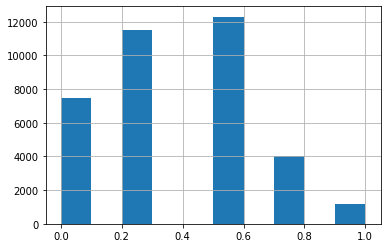

In [13]:
train['score'].hist()

In [14]:
display(train['context'].apply(lambda x: x[0]).value_counts())

B    8019
H    6195
G    6013
C    5288
A    4094
F    4054
E    1531
D    1279
Name: context, dtype: int64

- Y is not in training data, but may be in test data?

# CV split

In [15]:
# ====================================================
# CV split
# ====================================================
train['score_map'] = train['score'].map({0.00: 0, 0.25: 1, 0.50: 2, 0.75: 3, 1.00: 4})
Fold = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
for n, (train_index, val_index) in enumerate(Fold.split(train, train['score_map'])):
    train.loc[val_index, 'fold'] = int(n)
train['fold'] = train['fold'].astype(int)
display(train.groupby('fold').size())

fold
0    3648
1    3648
2    3648
3    3647
4    3647
5    3647
6    3647
7    3647
8    3647
9    3647
dtype: int64

In [16]:
# # ====================================================
# # CV split
# # ====================================================
# train['score_map'] = train['score'].map({0.00: 0, 0.25: 1, 0.50: 2, 0.75: 3, 1.00: 4})
# Fold = StratifiedGroupKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
# for n, (train_index, val_index) in enumerate(Fold.split(train, train['score_map'], train['anchor'])):
#     train.loc[val_index, 'fold'] = int(n)
# train['fold'] = train['fold'].astype(int)
# display(train.groupby('fold').size())

In [17]:
if CFG.debug:
    display(train.groupby('fold').size())
    train = train.sample(n=1000, random_state=0).reset_index(drop=True)
    display(train.groupby('fold').size())

# tokenizer

In [18]:
# ====================================================
# tokenizer
# ====================================================
! pip install sentencepiece
tokenizer = AutoTokenizer.from_pretrained(CFG.model)
tokenizer.save_pretrained(OUTPUT_DIR+'/tokenizer/')
CFG.tokenizer = tokenizer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Downloading:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/580 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.35M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


# Dataset

In [19]:
# ====================================================
# Define max_len
# ====================================================
lengths_dict = {}

lengths = []
tk0 = tqdm(cpc_texts.values(), total=len(cpc_texts))
for text in tk0:
    length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
    lengths.append(length)
lengths_dict['context_text'] = lengths

for text_col in ['anchor', 'target']:
    lengths = []
    tk0 = tqdm(train[text_col].fillna("").values, total=len(train))
    for text in tk0:
        length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
        lengths.append(length)
    lengths_dict[text_col] = lengths
    
CFG.max_len = max(lengths_dict['anchor']) + max(lengths_dict['target'])\
                + max(lengths_dict['context_text']) + 4 # CLS + SEP + SEP + SEP
LOGGER.info(f"max_len: {CFG.max_len}")

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/36473 [00:00<?, ?it/s]

  0%|          | 0/36473 [00:00<?, ?it/s]

max_len: 133


In [20]:
# ====================================================
# Dataset
# ====================================================
def prepare_input(cfg, text):
    inputs = cfg.tokenizer(text,
                           add_special_tokens=True,
                           max_length=cfg.max_len,
                           padding="max_length",
                           return_offsets_mapping=False)
    for k, v in inputs.items():
        inputs[k] = torch.tensor(v, dtype=torch.long)
    return inputs


class TrainDataset(Dataset):
    def __init__(self, cfg, df):
        self.cfg = cfg
        self.texts = df['text'].values
        self.labels = df['score'].values

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, item):
        inputs = prepare_input(self.cfg, self.texts[item])
        label = torch.tensor(self.labels[item], dtype=torch.float)
        return inputs, label

In [21]:
"""
train_dataset = TrainDataset(CFG, train)
inputs, label = train_dataset[0]
print(inputs)
print(label)
"""

'\ntrain_dataset = TrainDataset(CFG, train)\ninputs, label = train_dataset[0]\nprint(inputs)\nprint(label)\n'

# Model

In [22]:
class TransformerHead(nn.Module):
    def __init__(self, in_features, max_length, num_layers=1, nhead=8, num_targets=1):
        super().__init__()
        # in_features は各トークンに対するベクトルの次元数
        # max_length は最大トークン数
        self.transformer = nn.TransformerEncoder(encoder_layer=nn.TransformerEncoderLayer(d_model=in_features,
                                                                                          nhead=nhead),
                                                 num_layers=num_layers)
        self.row_fc = nn.Linear(in_features, 1)
        self.out_features = max_length

    def forward(self, x):
        out = self.transformer(x)
        out = self.row_fc(out).squeeze(-1)
        return out

In [23]:
# ====================================================
# Model
# ====================================================
class CustomModel(nn.Module):
    def __init__(self, cfg, config_path=None, pretrained=False):
        super().__init__()
        self.cfg = cfg
        if config_path is None:
            self.config = AutoConfig.from_pretrained(cfg.model, output_hidden_states=True)
        else:
            self.config = torch.load(config_path)
        if pretrained:
            self.model = AutoModel.from_pretrained(cfg.model, config=self.config)
        else:
            self.model = AutoModel.from_config(self.config)
        
        in_features = self.config.hidden_size
        self.attention = TransformerHead(in_features=in_features, max_length=cfg.max_len, num_layers=1, nhead=8, num_targets=1)
        self.fc_dropout = nn.Dropout(cfg.fc_dropout)
        self.fc = nn.Linear(self.attention.out_features, self.cfg.target_size)
        self._init_weights(self.fc)
        self._init_weights(self.attention)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        
    def feature(self, inputs):
        outputs = self.model(**inputs)
        last_hidden_states = outputs[0]
        # feature = torch.mean(last_hidden_states, 1)
        feature = self.attention(last_hidden_states)
        
        return feature

    def forward(self, inputs):
        feature = self.feature(inputs)
#         print(feature.shape)
        output = self.fc(self.fc_dropout(feature))
        return output, feature

# Helpler functions

In [24]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device):
    model.train()
    scaler = torch.cuda.amp.GradScaler(enabled=CFG.apex)
    losses = AverageMeter()
    start = end = time.time()
    global_step = 0
    for step, (inputs, labels) in enumerate(train_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.cuda.amp.autocast(enabled=CFG.apex):
            y_preds, _ = model(inputs)
        loss = criterion(y_preds.view(-1, 1), labels.view(-1, 1))
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            global_step += 1
            if CFG.batch_scheduler:
                scheduler.step()
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  'LR: {lr:.8f}  '
                  .format(epoch+1, step, len(train_loader), 
                          remain=timeSince(start, float(step+1)/len(train_loader)),
                          loss=losses,
                          grad_norm=grad_norm,
                          lr=scheduler.get_lr()[0]))
        if CFG.wandb:
            wandb.log({f"[fold{fold}] loss": losses.val,
                       f"[fold{fold}] lr": scheduler.get_lr()[0]})
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    losses = AverageMeter()
    model.eval()
    preds = []
    start = end = time.time()
    for step, (inputs, labels) in enumerate(valid_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.no_grad():
            y_preds, _ = model(inputs)
        loss = criterion(y_preds.view(-1, 1), labels.view(-1, 1))
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        preds.append(y_preds.sigmoid().to('cpu').numpy())
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(step, len(valid_loader),
                          loss=losses,
                          remain=timeSince(start, float(step+1)/len(valid_loader))))
    predictions = np.concatenate(preds)
    predictions = np.concatenate(predictions)
    return losses.avg, predictions


def inference_fn(test_loader, model, device):
    preds = []
    model.eval()
    model.to(device)
    tk0 = tqdm(test_loader, total=len(test_loader))
    for inputs in tk0:
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        with torch.no_grad():
            y_preds, _ = model(inputs)
        preds.append(y_preds.sigmoid().to('cpu').numpy())
    predictions = np.concatenate(preds)
    return predictions

In [25]:
### lightgbm
### 適当なやつ
def train_fn_(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device):
    from lightgbm import LGBMRegressor
    model.eval()

    embeds = []
    targets = []
    for step, (inputs, labels) in enumerate(train_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        with torch.no_grad():
            y_preds, embed = model(inputs)
        embeds.append(embed.to('cpu').numpy())
        targets.append(labels.to('cpu').numpy())
    embeds = np.concatenate(embeds) # (datasize, 768)
    targets = np.concatenate(targets) # (datasize, 1)
    
    params = {
    'objective': 'regression',
    'boosting_type': 'gbdt',  # default = 'gbdt'
    'num_leaves': 2**8-1, #63,         # default = 31,
    'learning_rate': 0.01,    # default = 0.1
    'feature_fraction': 0.8,  # default = 1.0
    'bagging_freq': 1,        # default = 0
    'bagging_fraction': 0.8,  # default = 1.0
    'random_state': 0,        # default = None
    'max_depth': 8,
#     'min_data_in_leaf': 50,   # default = 20
    'verbosity': -1,
}
    

    train_data = lgb.Dataset(
        data=embeds, 
        label=targets, 
    )

    bst = lgb.train(params=params, 
                    train_set=train_data, 
                    num_boost_round=10)

    return bst, embeds, targets

def valid_fn_(valid_loader, model, criterion, device, gbdt):
    model.eval()
    preds = []
    embeds = []
    targets = []
    for step, (inputs, labels) in enumerate(valid_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        with torch.no_grad():
            _, embed = model(inputs)
        embeds.append(embed.to('cpu').numpy())
        targets.append(labels.to('cpu').numpy())

        y_preds = gbdt.predict(embed.to('cpu').numpy())
        preds.append(y_preds)

    predictions = np.concatenate(preds)
    embeds = np.concatenate(embeds) # (datasize, 768)
    targets = np.concatenate(targets) # (datasize, 1)
#     predictions = np.concatenate(predictions)
    return predictions, embeds, targets


# ====================================================
# train loop
# ====================================================
def train_loop(folds, fold):
    
    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    train_folds = folds[folds['fold'] != fold].reset_index(drop=True)
    valid_folds = folds[folds['fold'] == fold].reset_index(drop=True)
    valid_labels = valid_folds['score'].values

    # newtrain ============================================
    if CFG.newtrain:
        path = os.path.join(INPUT_DIR, 'newtrain.csv')
        df = pd.read_csv(path)
        r = [0.95, 0.97, 0.7, 0.60, 0.98]
        m = ['0', '1', '2', '3', '4']
        new_df = []
        for i, j in zip(m, r):
            idx = df[i] > j
            df.loc[idx, 'score'] = int(i) * 0.25
            new_df.append(df[idx])
        new_train = pd.concat(new_df)
        train_folds = pd.concat([train_folds[['text', 'score']], new_train[['text', 'score']]])
    # ======================================================
    
    train_dataset = TrainDataset(CFG, train_folds)
    valid_dataset = TrainDataset(CFG, valid_folds)

    train_loader = DataLoader(train_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=True,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=False,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

    # ====================================================
    # model & optimizer
    # ====================================================
    model = CustomModel(CFG, config_path=None, pretrained=True)
    torch.save(model.config, OUTPUT_DIR+'/config.pth')
    model.to(device)
    
    def get_optimizer_params(model, encoder_lr, decoder_lr, weight_decay=0.0):
        param_optimizer = list(model.named_parameters())
        no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
        optimizer_parameters = [
            {'params': [p for n, p in model.model.named_parameters() if not any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': weight_decay},
            {'params': [p for n, p in model.model.named_parameters() if any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': 0.0},
            {'params': [p for n, p in model.named_parameters() if "model" not in n],
             'lr': decoder_lr, 'weight_decay': 0.0}
        ]
        return optimizer_parameters

    optimizer_parameters = get_optimizer_params(model,
                                                encoder_lr=CFG.encoder_lr, 
                                                decoder_lr=CFG.decoder_lr,
                                                weight_decay=CFG.weight_decay)
    optimizer = AdamW(optimizer_parameters, lr=CFG.encoder_lr, eps=CFG.eps, betas=CFG.betas)
    
    # ====================================================
    # scheduler
    # ====================================================
    def get_scheduler(cfg, optimizer, num_train_steps):
        if cfg.scheduler == 'linear':
            scheduler = get_linear_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps
            )
        elif cfg.scheduler == 'cosine':
            scheduler = get_cosine_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps, num_cycles=cfg.num_cycles
            )
        return scheduler
    
    num_train_steps = int(len(train_folds) / CFG.batch_size * CFG.epochs)
    scheduler = get_scheduler(CFG, optimizer, num_train_steps)

    # ====================================================
    # loop
    # ====================================================
    criterion = nn.BCEWithLogitsLoss(reduction="mean")
    
    best_score = 0.

    for epoch in range(CFG.epochs):

        start_time = time.time()

        # train
        avg_loss = train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device)
        
        # lightgbm train
        gbdt, embeds_tr, targets_tr = train_fn_(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device)

        # eval
        predictions, embeds_va, targets_va = valid_fn_(valid_loader, model, criterion, device, gbdt)
        
        # scoring
        score = get_score(valid_labels, predictions)

        elapsed = time.time() - start_time

#         LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}')
        if CFG.wandb:
            wandb.log({f"[fold{fold}] epoch": epoch+1, 
                       f"[fold{fold}] avg_train_loss": avg_loss, 
                       f"[fold{fold}] avg_val_loss": avg_val_loss,
                       f"[fold{fold}] score": score})
        
        if best_score < score:
            best_score = score
            torch.save({'model': model.state_dict(),
                        'predictions': predictions},
                        OUTPUT_DIR+f"/{CFG.model.replace('/', '-')}_fold{fold}_best.pth")
            gbdt.save_model(OUTPUT_DIR+f"/{CFG.model.replace('/', '-')}_fold{fold}_best_gbdt.txt")
        
            np.save(OUTPUT_DIR+f"/{CFG.model.replace('/', '-')}_fold{fold}_embeds_tr", embeds_tr)
            np.save(OUTPUT_DIR+f"/{CFG.model.replace('/', '-')}_fold{fold}_targets_tr", targets_tr)
            np.save(OUTPUT_DIR+f"/{CFG.model.replace('/', '-')}_fold{fold}_embeds_va", embeds_va)
            np.save(OUTPUT_DIR+f"/{CFG.model.replace('/', '-')}_fold{fold}_targets_va", targets_va)

    predictions = torch.load(OUTPUT_DIR+f"/{CFG.model.replace('/', '-')}_fold{fold}_best.pth", 
                             map_location=torch.device('cpu'))['predictions'] #bestmodelのpredictionをとりだす
    ### round
#     predictions *= 4
#     predictions = predictions.round() / 4
    valid_folds['pred'] = predictions
    valid_folds['pred'].hist(bins=100)

    torch.cuda.empty_cache()
    gc.collect()
    
    return valid_folds


========== fold: 0 training ==========


Downloading:   0%|          | 0.00/833M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['mask_predictions.dense.bias', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.LayerNorm.bias', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.dense.weight', 'mask_predictions.LayerNorm.weight', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: [1][0/2051] Elapsed 0m 2s (remain 78m 46s) Loss: 0.6838(0.6838) Grad: 48880.6562  LR: 0.00000003  
Epoch: [1][100/2051] Elapsed 1m 39s (remain 31m 52s) Loss: 0.6547(0.6682) Grad: 57607.0625  LR: 0.00000303  
Epoch: [1][200/2051] Elapsed 3m 15s (remain 30m 0s) Loss: 0.6517(0.6652) Grad: 36998.8047  LR: 0.00000603  
Epoch: [1][300/2051] Elapsed 4m 52s (remain 28m 18s) Loss: 0.6902(0.6632) Grad: 84058.0938  LR: 0.00000903  
Epoch: [1][400/2051] Elapsed 6m 28s (remain 26m 39s) Loss: 0.6211(0.6593) Grad: 50414.5938  LR: 0.00001203  
Epoch: [1][500/2051] Elapsed 8m 5s (remain 25m 1s) Loss: 0.6002(0.6536) Grad: 130125.8750  LR: 0.00001500  
Epoch: [1][600/2051] Elapsed 9m 41s (remain 23m 24s) Loss: 0.5234(0.6454) Grad: 148798.6719  LR: 0.00001499  
Epoch: [1][700/2051] Elapsed 11m 18s (remain 21m 46s) Loss: 0.5567(0.6400) Grad: 115447.9219  LR: 0.00001497  
Epoch: [1][800/2051] Elapsed 12m 55s (remain 20m 9s) Loss: 0.6164(0.6333) Grad: 148429.2969  LR: 0.00001494  
Epoch: [1][900/2051]

Epoch 1 - Score: 0.8507


Epoch: [2][0/2051] Elapsed 0m 1s (remain 46m 55s) Loss: 0.6217(0.6217) Grad: 78345.5078  LR: 0.00001355  
Epoch: [2][100/2051] Elapsed 1m 38s (remain 31m 33s) Loss: 0.5702(0.5397) Grad: 88901.6875  LR: 0.00001336  
Epoch: [2][200/2051] Elapsed 3m 14s (remain 29m 49s) Loss: 0.5529(0.5355) Grad: 78744.1562  LR: 0.00001317  
Epoch: [2][300/2051] Elapsed 4m 50s (remain 28m 10s) Loss: 0.5745(0.5374) Grad: 36592.7305  LR: 0.00001296  
Epoch: [2][400/2051] Elapsed 6m 27s (remain 26m 33s) Loss: 0.5903(0.5381) Grad: 107482.3438  LR: 0.00001275  
Epoch: [2][500/2051] Elapsed 8m 3s (remain 24m 56s) Loss: 0.4828(0.5376) Grad: 54660.9766  LR: 0.00001253  
Epoch: [2][600/2051] Elapsed 9m 40s (remain 23m 19s) Loss: 0.5910(0.5377) Grad: 39471.5664  LR: 0.00001229  
Epoch: [2][700/2051] Elapsed 11m 16s (remain 21m 42s) Loss: 0.6207(0.5372) Grad: 38658.2266  LR: 0.00001205  
Epoch: [2][800/2051] Elapsed 12m 52s (remain 20m 6s) Loss: 0.5440(0.5380) Grad: 77606.4297  LR: 0.00001181  
Epoch: [2][900/2051] 

Epoch 2 - Score: 0.8649


Epoch: [3][0/2051] Elapsed 0m 1s (remain 42m 20s) Loss: 0.5302(0.5302) Grad: 97045.4531  LR: 0.00000826  
Epoch: [3][100/2051] Elapsed 1m 37s (remain 31m 29s) Loss: 0.4772(0.5203) Grad: 33279.0469  LR: 0.00000796  
Epoch: [3][200/2051] Elapsed 3m 14s (remain 29m 49s) Loss: 0.6228(0.5220) Grad: 99016.3438  LR: 0.00000765  
Epoch: [3][300/2051] Elapsed 4m 50s (remain 28m 11s) Loss: 0.4810(0.5165) Grad: 56730.7148  LR: 0.00000735  
Epoch: [3][400/2051] Elapsed 6m 27s (remain 26m 33s) Loss: 0.5448(0.5164) Grad: 34462.5195  LR: 0.00000704  
Epoch: [3][500/2051] Elapsed 8m 3s (remain 24m 56s) Loss: 0.4269(0.5171) Grad: 108835.9297  LR: 0.00000674  
Epoch: [3][600/2051] Elapsed 9m 40s (remain 23m 19s) Loss: 0.5286(0.5173) Grad: 21825.7852  LR: 0.00000643  
Epoch: [3][700/2051] Elapsed 11m 16s (remain 21m 43s) Loss: 0.3560(0.5172) Grad: 34407.9805  LR: 0.00000613  
Epoch: [3][800/2051] Elapsed 12m 53s (remain 20m 6s) Loss: 0.6444(0.5177) Grad: 122330.5703  LR: 0.00000583  
Epoch: [3][900/2051]

Epoch 3 - Score: 0.8722


Epoch: [4][0/2051] Elapsed 0m 1s (remain 42m 44s) Loss: 0.4951(0.4951) Grad: 133083.4688  LR: 0.00000247  
Epoch: [4][100/2051] Elapsed 1m 37s (remain 31m 29s) Loss: 0.4048(0.5053) Grad: 74823.5078  LR: 0.00000225  
Epoch: [4][200/2051] Elapsed 3m 14s (remain 29m 47s) Loss: 0.6278(0.5084) Grad: 69965.7734  LR: 0.00000204  
Epoch: [4][300/2051] Elapsed 4m 50s (remain 28m 9s) Loss: 0.4421(0.5059) Grad: 17889.9180  LR: 0.00000183  
Epoch: [4][400/2051] Elapsed 6m 26s (remain 26m 32s) Loss: 0.4249(0.5047) Grad: 16597.0742  LR: 0.00000164  
Epoch: [4][500/2051] Elapsed 8m 3s (remain 24m 56s) Loss: 0.4995(0.5061) Grad: 30970.2949  LR: 0.00000145  
Epoch: [4][600/2051] Elapsed 9m 39s (remain 23m 19s) Loss: 0.5224(0.5062) Grad: 38300.3164  LR: 0.00000128  
Epoch: [4][700/2051] Elapsed 11m 16s (remain 21m 42s) Loss: 0.5896(0.5056) Grad: 35177.1562  LR: 0.00000111  
Epoch: [4][800/2051] Elapsed 12m 52s (remain 20m 6s) Loss: 0.4878(0.5072) Grad: 42180.9375  LR: 0.00000096  
Epoch: [4][900/2051] E

Epoch 4 - Score: 0.8731
========== fold: 0 result ==========
Score: 0.8731
========== fold: 1 training ==========
Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['mask_predictions.dense.bias', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.LayerNorm.bias', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.dense.weight', 'mask_predictions.LayerNorm.weight', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (in

Epoch: [1][0/2051] Elapsed 0m 2s (remain 90m 45s) Loss: 0.6968(0.6968) Grad: 132570.9375  LR: 0.00000003  
Epoch: [1][100/2051] Elapsed 1m 39s (remain 31m 57s) Loss: 0.6346(0.6729) Grad: 45000.9141  LR: 0.00000303  
Epoch: [1][200/2051] Elapsed 3m 15s (remain 30m 1s) Loss: 0.6352(0.6690) Grad: 46218.9570  LR: 0.00000603  
Epoch: [1][300/2051] Elapsed 4m 52s (remain 28m 18s) Loss: 0.6800(0.6642) Grad: 45972.7812  LR: 0.00000903  
Epoch: [1][400/2051] Elapsed 6m 28s (remain 26m 38s) Loss: 0.6657(0.6541) Grad: 105131.3281  LR: 0.00001203  
Epoch: [1][500/2051] Elapsed 8m 4s (remain 25m 0s) Loss: 0.5723(0.6422) Grad: 127572.6406  LR: 0.00001500  
Epoch: [1][600/2051] Elapsed 9m 41s (remain 23m 22s) Loss: 0.5917(0.6319) Grad: 165563.2500  LR: 0.00001499  
Epoch: [1][700/2051] Elapsed 11m 17s (remain 21m 45s) Loss: 0.6331(0.6238) Grad: 208027.3750  LR: 0.00001497  
Epoch: [1][800/2051] Elapsed 12m 54s (remain 20m 7s) Loss: 0.5158(0.6171) Grad: 86421.4219  LR: 0.00001494  
Epoch: [1][900/2051

Epoch 1 - Score: 0.8449


Epoch: [2][0/2051] Elapsed 0m 1s (remain 42m 12s) Loss: 0.4466(0.4466) Grad: 78799.4375  LR: 0.00001355  
Epoch: [2][100/2051] Elapsed 1m 37s (remain 31m 26s) Loss: 0.5492(0.5357) Grad: 107602.1172  LR: 0.00001336  
Epoch: [2][200/2051] Elapsed 3m 14s (remain 29m 47s) Loss: 0.5999(0.5343) Grad: 104221.8750  LR: 0.00001317  
Epoch: [2][300/2051] Elapsed 4m 50s (remain 28m 8s) Loss: 0.5215(0.5345) Grad: 54863.1719  LR: 0.00001296  
Epoch: [2][400/2051] Elapsed 6m 26s (remain 26m 31s) Loss: 0.6034(0.5313) Grad: 64819.4023  LR: 0.00001275  
Epoch: [2][500/2051] Elapsed 8m 3s (remain 24m 54s) Loss: 0.5623(0.5322) Grad: 52983.1406  LR: 0.00001253  
Epoch: [2][600/2051] Elapsed 9m 39s (remain 23m 17s) Loss: 0.5796(0.5330) Grad: 34440.5820  LR: 0.00001229  
Epoch: [2][700/2051] Elapsed 11m 15s (remain 21m 41s) Loss: 0.4737(0.5326) Grad: 44847.3672  LR: 0.00001205  
Epoch: [2][800/2051] Elapsed 12m 51s (remain 20m 4s) Loss: 0.4213(0.5315) Grad: 57149.3867  LR: 0.00001181  
Epoch: [2][900/2051] 

Epoch 2 - Score: 0.8569


Epoch: [3][0/2051] Elapsed 0m 1s (remain 43m 21s) Loss: 0.5470(0.5470) Grad: 120939.8047  LR: 0.00000826  
Epoch: [3][100/2051] Elapsed 1m 37s (remain 31m 26s) Loss: 0.5518(0.5046) Grad: 110523.1562  LR: 0.00000796  
Epoch: [3][200/2051] Elapsed 3m 14s (remain 29m 45s) Loss: 0.4547(0.5065) Grad: 58599.3711  LR: 0.00000765  
Epoch: [3][300/2051] Elapsed 4m 50s (remain 28m 7s) Loss: 0.5004(0.5100) Grad: 40188.2773  LR: 0.00000735  
Epoch: [3][400/2051] Elapsed 6m 26s (remain 26m 30s) Loss: 0.4868(0.5102) Grad: 30093.4121  LR: 0.00000704  
Epoch: [3][500/2051] Elapsed 8m 3s (remain 24m 54s) Loss: 0.5665(0.5141) Grad: 118732.8594  LR: 0.00000674  
Epoch: [3][600/2051] Elapsed 9m 39s (remain 23m 17s) Loss: 0.3591(0.5126) Grad: 71620.0000  LR: 0.00000643  
Epoch: [3][700/2051] Elapsed 11m 15s (remain 21m 41s) Loss: 0.5353(0.5130) Grad: 168413.7969  LR: 0.00000613  
Epoch: [3][800/2051] Elapsed 12m 51s (remain 20m 4s) Loss: 0.6393(0.5125) Grad: 282612.3750  LR: 0.00000583  
Epoch: [3][900/205

Epoch 3 - Score: 0.8658


Epoch: [4][0/2051] Elapsed 0m 1s (remain 43m 4s) Loss: 0.5647(0.5647) Grad: 229868.4375  LR: 0.00000247  
Epoch: [4][100/2051] Elapsed 1m 37s (remain 31m 31s) Loss: 0.5068(0.5054) Grad: 57860.9062  LR: 0.00000225  
Epoch: [4][200/2051] Elapsed 3m 14s (remain 29m 48s) Loss: 0.5541(0.5061) Grad: 207847.2031  LR: 0.00000204  
Epoch: [4][300/2051] Elapsed 4m 50s (remain 28m 10s) Loss: 0.4666(0.5072) Grad: 42750.6836  LR: 0.00000183  
Epoch: [4][400/2051] Elapsed 6m 27s (remain 26m 32s) Loss: 0.4239(0.5061) Grad: 35836.4258  LR: 0.00000164  
Epoch: [4][500/2051] Elapsed 8m 3s (remain 24m 55s) Loss: 0.5100(0.5070) Grad: 112928.5000  LR: 0.00000145  
Epoch: [4][600/2051] Elapsed 9m 39s (remain 23m 18s) Loss: 0.5705(0.5077) Grad: 74726.0469  LR: 0.00000128  
Epoch: [4][700/2051] Elapsed 11m 16s (remain 21m 42s) Loss: 0.4234(0.5073) Grad: 22973.3672  LR: 0.00000111  
Epoch: [4][800/2051] Elapsed 12m 52s (remain 20m 5s) Loss: 0.3530(0.5070) Grad: 14786.8604  LR: 0.00000096  
Epoch: [4][900/2051]

Epoch 4 - Score: 0.8672
========== fold: 1 result ==========
Score: 0.8672
========== fold: 2 training ==========
Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['mask_predictions.dense.bias', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.LayerNorm.bias', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.dense.weight', 'mask_predictions.LayerNorm.weight', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (in

Epoch: [1][0/2051] Elapsed 0m 2s (remain 101m 38s) Loss: 0.7004(0.7004) Grad: 119244.4375  LR: 0.00000003  
Epoch: [1][100/2051] Elapsed 1m 39s (remain 32m 3s) Loss: 0.6845(0.6922) Grad: 82508.8281  LR: 0.00000303  
Epoch: [1][200/2051] Elapsed 3m 16s (remain 30m 4s) Loss: 0.6635(0.6762) Grad: 72276.7656  LR: 0.00000603  
Epoch: [1][300/2051] Elapsed 4m 52s (remain 28m 20s) Loss: 0.6934(0.6720) Grad: 79066.8750  LR: 0.00000903  
Epoch: [1][400/2051] Elapsed 6m 28s (remain 26m 39s) Loss: 0.6569(0.6672) Grad: 67099.4062  LR: 0.00001203  
Epoch: [1][500/2051] Elapsed 8m 5s (remain 25m 0s) Loss: 0.6895(0.6652) Grad: 73829.8125  LR: 0.00001500  
Epoch: [1][600/2051] Elapsed 9m 41s (remain 23m 23s) Loss: 0.5707(0.6570) Grad: 56901.1523  LR: 0.00001499  
Epoch: [1][700/2051] Elapsed 11m 17s (remain 21m 45s) Loss: 0.5508(0.6488) Grad: 58366.8867  LR: 0.00001497  
Epoch: [1][800/2051] Elapsed 12m 54s (remain 20m 8s) Loss: 0.5963(0.6415) Grad: 52974.1133  LR: 0.00001494  
Epoch: [1][900/2051] El

Epoch 1 - Score: 0.8244


Epoch: [2][0/2051] Elapsed 0m 1s (remain 43m 7s) Loss: 0.4685(0.4685) Grad: 79669.8828  LR: 0.00001355  
Epoch: [2][100/2051] Elapsed 1m 37s (remain 31m 29s) Loss: 0.5245(0.5409) Grad: 34329.1484  LR: 0.00001336  
Epoch: [2][200/2051] Elapsed 3m 14s (remain 29m 47s) Loss: 0.6296(0.5439) Grad: 177610.7188  LR: 0.00001317  
Epoch: [2][300/2051] Elapsed 4m 51s (remain 28m 12s) Loss: 0.5658(0.5417) Grad: 23723.3750  LR: 0.00001296  
Epoch: [2][400/2051] Elapsed 6m 27s (remain 26m 34s) Loss: 0.6558(0.5403) Grad: 64228.3164  LR: 0.00001275  
Epoch: [2][500/2051] Elapsed 8m 3s (remain 24m 56s) Loss: 0.5124(0.5384) Grad: 59269.7930  LR: 0.00001253  
Epoch: [2][600/2051] Elapsed 9m 40s (remain 23m 19s) Loss: 0.6146(0.5374) Grad: 110401.1953  LR: 0.00001229  
Epoch: [2][700/2051] Elapsed 11m 16s (remain 21m 43s) Loss: 0.5380(0.5354) Grad: 23485.1738  LR: 0.00001205  
Epoch: [2][800/2051] Elapsed 12m 53s (remain 20m 6s) Loss: 0.5292(0.5346) Grad: 29815.2793  LR: 0.00001181  
Epoch: [2][900/2051] 

Epoch 2 - Score: 0.8538


Epoch: [3][0/2051] Elapsed 0m 1s (remain 42m 55s) Loss: 0.4415(0.4415) Grad: 77662.6094  LR: 0.00000826  
Epoch: [3][100/2051] Elapsed 1m 37s (remain 31m 29s) Loss: 0.6353(0.5185) Grad: 73124.5391  LR: 0.00000796  
Epoch: [3][200/2051] Elapsed 3m 14s (remain 29m 47s) Loss: 0.4882(0.5178) Grad: 45028.3477  LR: 0.00000765  
Epoch: [3][300/2051] Elapsed 4m 50s (remain 28m 9s) Loss: 0.4748(0.5190) Grad: 66544.5859  LR: 0.00000735  
Epoch: [3][400/2051] Elapsed 6m 26s (remain 26m 32s) Loss: 0.4531(0.5180) Grad: 22432.7305  LR: 0.00000704  
Epoch: [3][500/2051] Elapsed 8m 3s (remain 24m 55s) Loss: 0.4503(0.5177) Grad: 19876.1270  LR: 0.00000674  
Epoch: [3][600/2051] Elapsed 9m 40s (remain 23m 19s) Loss: 0.4301(0.5172) Grad: 27282.1602  LR: 0.00000643  
Epoch: [3][700/2051] Elapsed 11m 16s (remain 21m 42s) Loss: 0.4742(0.5165) Grad: 14864.6074  LR: 0.00000613  
Epoch: [3][800/2051] Elapsed 12m 52s (remain 20m 5s) Loss: 0.4705(0.5165) Grad: 29477.1523  LR: 0.00000583  
Epoch: [3][900/2051] El

Epoch 3 - Score: 0.8617


Epoch: [4][0/2051] Elapsed 0m 1s (remain 43m 13s) Loss: 0.5441(0.5441) Grad: 59891.4688  LR: 0.00000247  
Epoch: [4][100/2051] Elapsed 1m 37s (remain 31m 29s) Loss: 0.4931(0.5012) Grad: 265647.3438  LR: 0.00000225  
Epoch: [4][200/2051] Elapsed 3m 14s (remain 29m 47s) Loss: 0.6019(0.5031) Grad: 184520.4062  LR: 0.00000204  
Epoch: [4][300/2051] Elapsed 4m 50s (remain 28m 8s) Loss: 0.4533(0.5035) Grad: 30069.2891  LR: 0.00000183  
Epoch: [4][400/2051] Elapsed 6m 26s (remain 26m 31s) Loss: 0.5559(0.5037) Grad: 138219.4062  LR: 0.00000164  
Epoch: [4][500/2051] Elapsed 8m 3s (remain 24m 55s) Loss: 0.5491(0.5037) Grad: 38795.4805  LR: 0.00000145  
Epoch: [4][600/2051] Elapsed 9m 39s (remain 23m 18s) Loss: 0.5319(0.5026) Grad: 37351.3086  LR: 0.00000128  
Epoch: [4][700/2051] Elapsed 11m 15s (remain 21m 41s) Loss: 0.5432(0.5011) Grad: 120317.9766  LR: 0.00000111  
Epoch: [4][800/2051] Elapsed 12m 52s (remain 20m 5s) Loss: 0.5854(0.5019) Grad: 25538.1309  LR: 0.00000096  
Epoch: [4][900/2051

Epoch 4 - Score: 0.8618
========== fold: 2 result ==========
Score: 0.8618
========== fold: 3 training ==========
Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['mask_predictions.dense.bias', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.LayerNorm.bias', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.dense.weight', 'mask_predictions.LayerNorm.weight', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (in

Epoch: [1][0/2051] Elapsed 0m 2s (remain 86m 36s) Loss: 0.6504(0.6504) Grad: 146119.4219  LR: 0.00000003  
Epoch: [1][100/2051] Elapsed 1m 39s (remain 31m 53s) Loss: 0.6888(0.6546) Grad: 76878.7031  LR: 0.00000303  
Epoch: [1][200/2051] Elapsed 3m 15s (remain 29m 57s) Loss: 0.6773(0.6561) Grad: 78440.2266  LR: 0.00000603  
Epoch: [1][300/2051] Elapsed 4m 51s (remain 28m 15s) Loss: 0.6712(0.6567) Grad: 59420.9453  LR: 0.00000903  
Epoch: [1][400/2051] Elapsed 6m 27s (remain 26m 35s) Loss: 0.6522(0.6563) Grad: 49582.3555  LR: 0.00001203  
Epoch: [1][500/2051] Elapsed 8m 4s (remain 24m 57s) Loss: 0.6891(0.6539) Grad: 142252.2031  LR: 0.00001500  
Epoch: [1][600/2051] Elapsed 9m 40s (remain 23m 20s) Loss: 0.5623(0.6484) Grad: 151319.8594  LR: 0.00001499  
Epoch: [1][700/2051] Elapsed 11m 16s (remain 21m 43s) Loss: 0.6193(0.6423) Grad: 128709.4531  LR: 0.00001497  
Epoch: [1][800/2051] Elapsed 12m 52s (remain 20m 6s) Loss: 0.4818(0.6363) Grad: 112495.2969  LR: 0.00001494  
Epoch: [1][900/20

Epoch 1 - Score: 0.8146


Epoch: [2][0/2051] Elapsed 0m 1s (remain 43m 8s) Loss: 0.5021(0.5021) Grad: 30803.0234  LR: 0.00001355  
Epoch: [2][100/2051] Elapsed 1m 37s (remain 31m 27s) Loss: 0.6893(0.5376) Grad: 368172.6250  LR: 0.00001336  
Epoch: [2][200/2051] Elapsed 3m 14s (remain 29m 45s) Loss: 0.4451(0.5353) Grad: 22103.9473  LR: 0.00001317  
Epoch: [2][300/2051] Elapsed 4m 50s (remain 28m 9s) Loss: 0.4923(0.5356) Grad: 23866.7871  LR: 0.00001296  
Epoch: [2][400/2051] Elapsed 6m 26s (remain 26m 31s) Loss: 0.5567(0.5365) Grad: 6975.5718  LR: 0.00001275  
Epoch: [2][500/2051] Elapsed 8m 3s (remain 24m 54s) Loss: 0.3769(0.5350) Grad: 35503.1523  LR: 0.00001253  
Epoch: [2][600/2051] Elapsed 9m 39s (remain 23m 18s) Loss: 0.6699(0.5355) Grad: 35098.5430  LR: 0.00001229  
Epoch: [2][700/2051] Elapsed 11m 15s (remain 21m 41s) Loss: 0.5483(0.5342) Grad: 24780.2188  LR: 0.00001205  
Epoch: [2][800/2051] Elapsed 12m 52s (remain 20m 5s) Loss: 0.5548(0.5336) Grad: 49459.3320  LR: 0.00001181  
Epoch: [2][900/2051] Ela

Epoch 2 - Score: 0.8413


Epoch: [3][0/2051] Elapsed 0m 1s (remain 42m 7s) Loss: 0.4786(0.4786) Grad: 82828.8438  LR: 0.00000826  
Epoch: [3][100/2051] Elapsed 1m 37s (remain 31m 31s) Loss: 0.6016(0.5270) Grad: 30220.4277  LR: 0.00000796  
Epoch: [3][200/2051] Elapsed 3m 14s (remain 29m 48s) Loss: 0.5680(0.5195) Grad: 16161.5586  LR: 0.00000765  
Epoch: [3][300/2051] Elapsed 4m 50s (remain 28m 10s) Loss: 0.4267(0.5171) Grad: 34713.1367  LR: 0.00000735  
Epoch: [3][400/2051] Elapsed 6m 27s (remain 26m 32s) Loss: 0.5828(0.5186) Grad: 32743.9727  LR: 0.00000704  
Epoch: [3][500/2051] Elapsed 8m 3s (remain 24m 56s) Loss: 0.4487(0.5180) Grad: 31303.3770  LR: 0.00000674  
Epoch: [3][600/2051] Elapsed 9m 40s (remain 23m 19s) Loss: 0.4057(0.5171) Grad: 28359.9375  LR: 0.00000643  
Epoch: [3][700/2051] Elapsed 11m 16s (remain 21m 42s) Loss: 0.4732(0.5168) Grad: 16935.0918  LR: 0.00000613  
Epoch: [3][800/2051] Elapsed 12m 52s (remain 20m 6s) Loss: 0.5531(0.5155) Grad: 67104.2734  LR: 0.00000583  
Epoch: [3][900/2051] El

Epoch 3 - Score: 0.8551


Epoch: [4][0/2051] Elapsed 0m 1s (remain 43m 23s) Loss: 0.5342(0.5342) Grad: 432962.3750  LR: 0.00000247  
Epoch: [4][100/2051] Elapsed 1m 37s (remain 31m 31s) Loss: 0.4017(0.5052) Grad: 81779.7188  LR: 0.00000225  
Epoch: [4][200/2051] Elapsed 3m 14s (remain 29m 48s) Loss: 0.4525(0.5031) Grad: 79017.9531  LR: 0.00000204  
Epoch: [4][300/2051] Elapsed 4m 50s (remain 28m 10s) Loss: 0.4572(0.5020) Grad: 119239.9609  LR: 0.00000183  
Epoch: [4][400/2051] Elapsed 6m 27s (remain 26m 32s) Loss: 0.5164(0.5024) Grad: 69964.0938  LR: 0.00000164  
Epoch: [4][500/2051] Elapsed 8m 3s (remain 24m 55s) Loss: 0.6278(0.5042) Grad: 25042.6230  LR: 0.00000145  
Epoch: [4][600/2051] Elapsed 9m 39s (remain 23m 18s) Loss: 0.4886(0.5049) Grad: 9970.2705  LR: 0.00000128  
Epoch: [4][700/2051] Elapsed 11m 16s (remain 21m 42s) Loss: 0.5171(0.5051) Grad: 211487.2969  LR: 0.00000111  
Epoch: [4][800/2051] Elapsed 12m 52s (remain 20m 5s) Loss: 0.4364(0.5062) Grad: 47568.7031  LR: 0.00000096  
Epoch: [4][900/2051]

Epoch 4 - Score: 0.8547
========== fold: 3 result ==========
Score: 0.8551
========== CV ==========
Score: 0.8642


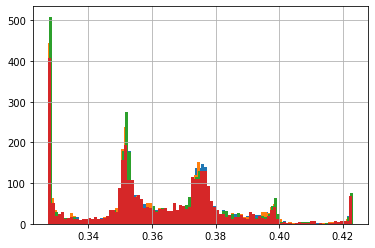

In [26]:
if __name__ == '__main__':
    
    def get_result(oof_df):
        labels = oof_df['score'].values
        preds = oof_df['pred'].values
        score = get_score(labels, preds)
        LOGGER.info(f'Score: {score:<.4f}')
    
    if CFG.train:
        oof_df = pd.DataFrame()
        for fold in range(CFG.n_fold):
            if fold in CFG.trn_fold:
                _oof_df = train_loop(train, fold)
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"========== fold: {fold} result ==========")
                get_result(_oof_df)
        oof_df = oof_df.reset_index(drop=True)
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)
        oof_df.to_pickle(OUTPUT_DIR+'/oof_df.pkl')
        
    if CFG.wandb:
        wandb.finish()